### Notebook for the undifferentiated fetal cells transition matrix calculation with CellRank Experimental Time

- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Created date:** 20th May 2024
- **Last modified date:** 20th May 2024

### Import packages

In [3]:
import numpy as np
import pandas as pd

import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

from moscot.problems.time import TemporalProblem

import matplotlib.pyplot as plt


### Set up the cells

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.3.0
absl                        NA
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.3
cellrank                    2.0.4
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.86
click                       8.1.7
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.2
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
dee

In [5]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [7]:
input = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/Fetal_undifferentiated_cells.h5ad'
adata = sc.read_h5ad(input)

In [8]:
X_is_raw(adata)

True

+ Normalization

In [9]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


- Calculate PCA and neighbors

In [10]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)


- Prepare timepoints column

In [11]:
adata.obs['Age'].value_counts() 

Age
9.2Wk     3748
9.9Wk     2909
16Wk      2495
7.9Wk     2308
15Wk      2217
10.2Wk    1887
6.7Wk     1585
10Wk      1436
11.1Wk    1306
6.9Wk     1008
7.4Wk      665
17Wk       639
8.4Wk      510
6.1Wk      136
12Wk       136
Name: count, dtype: int64

- Transform weeks into days to get unteger values

In [12]:
# Split column Age by space
adata.obs['Development_Week'] = adata.obs['Age'].str.split('Wk').str[0]
adata.obs['Development_Week'] = adata.obs['Development_Week'].astype(float)

# Transform weeks in days
adata.obs['Development_Day'] = adata.obs['Development_Week'] * 7

In [13]:
adata.obs['Development_Day'] = adata.obs['Development_Day'].astype(int)
adata.obs['Development_Day'] = adata.obs['Development_Day'].astype('category')

# Reconstruct differentiation trajectories across time points

### Run moscot to couple cells

In [14]:
tp = TemporalProblem(adata)

In [15]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

computing score 'proliferation'
    finished: added
    'proliferation', score of gene set (adata.obs).
    597 total control genes are used. (0:00:00)
computing score 'apoptosis'
    finished: added
    'apoptosis', score of gene set (adata.obs).
    1097 total control genes are used. (0:00:00)


In [16]:
tp = tp.prepare(time_key="Development_Day")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:02)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:04)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:02)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:02)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:01)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    w

In [17]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `14` problems                                                                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1436, 1887)].                                  


CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated CUDA installation found.
Version JAX was built against: 11080
Minimum supported: 12010
Installed version: 11080
The local installation version must be no lower than 12010.
--------------------------------------------------
Outdated cuBLAS installation found.
Version JAX was built against: 111103
Minimum supported: 120100
Installed version: 111103
The local installation version must be no lower than 120100.
--------------------------------------------------
Outdated cuSPARSE installation found.
Version JAX was built against: 11705
Minimum supported: 12100
Installed version: 11705
The local installation version must be no lower than 12100..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3748, 2909)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1887, 1306)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2495, 639)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1306, 136)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(665, 2308)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1585, 1008)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1008, 665)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2308, 510)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(510,

### Set up the RealTimeKernel

In [18]:
tmk = RealTimeKernel.from_moscot(tp)

In [19]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|█████████████████████████████████████████████████████| 14/14 [00:00<00:00, 192525.43time pair/s]

Using automatic `threshold=0.0`


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbor

RealTimeKernel[n=22985, threshold='auto', self_transitions='all']

### Visualize the recovered dynamics

Simulating `100` random walks of maximum length `500`


100%|█████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.96sim/s]

    Finish (0:00:09)


Plotting random walks


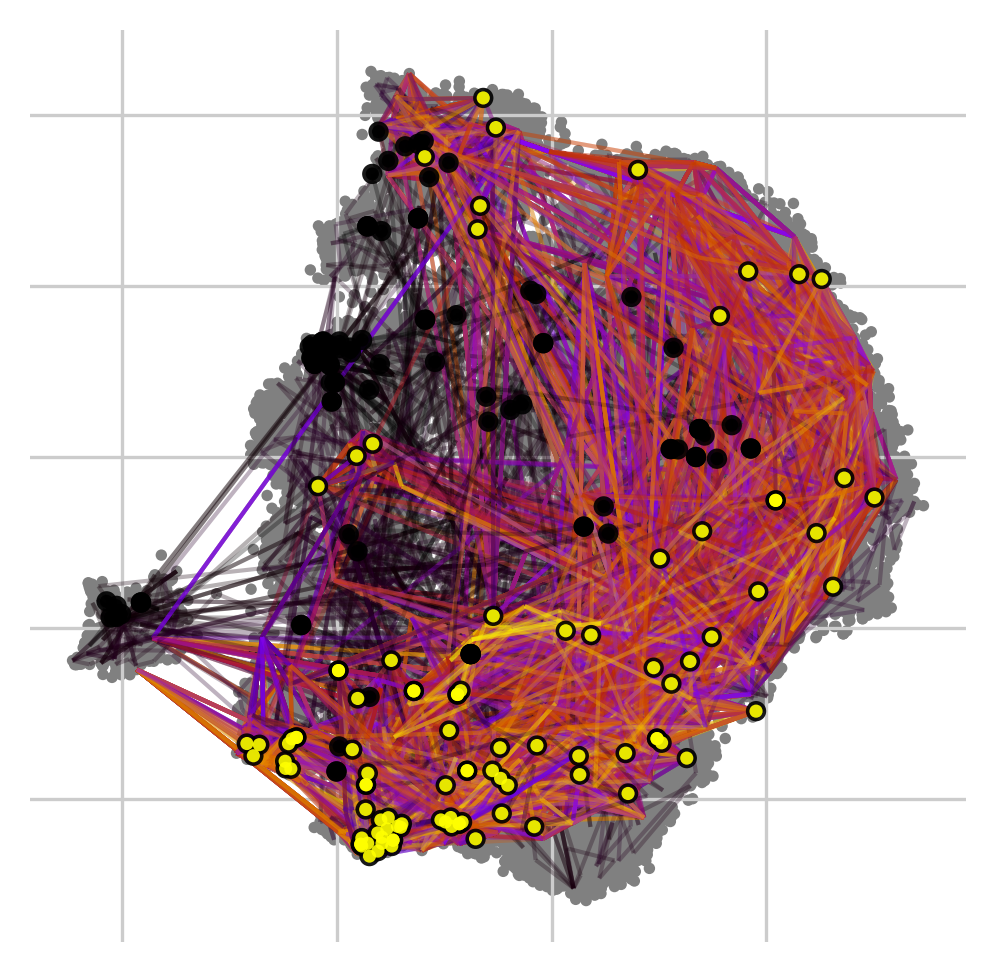

In [20]:
sc.set_figure_params(dpi=300)
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"Development_Day": 42},
    seed=0,
    dpi=150,
    size=30,
)


Computing flow from `FXYD3+_CKB+_SC` into `7` cluster(s) in `14` time points
Plotting flow from `FXYD3+_CKB+_SC` into `7` cluster(s) in `14` time points


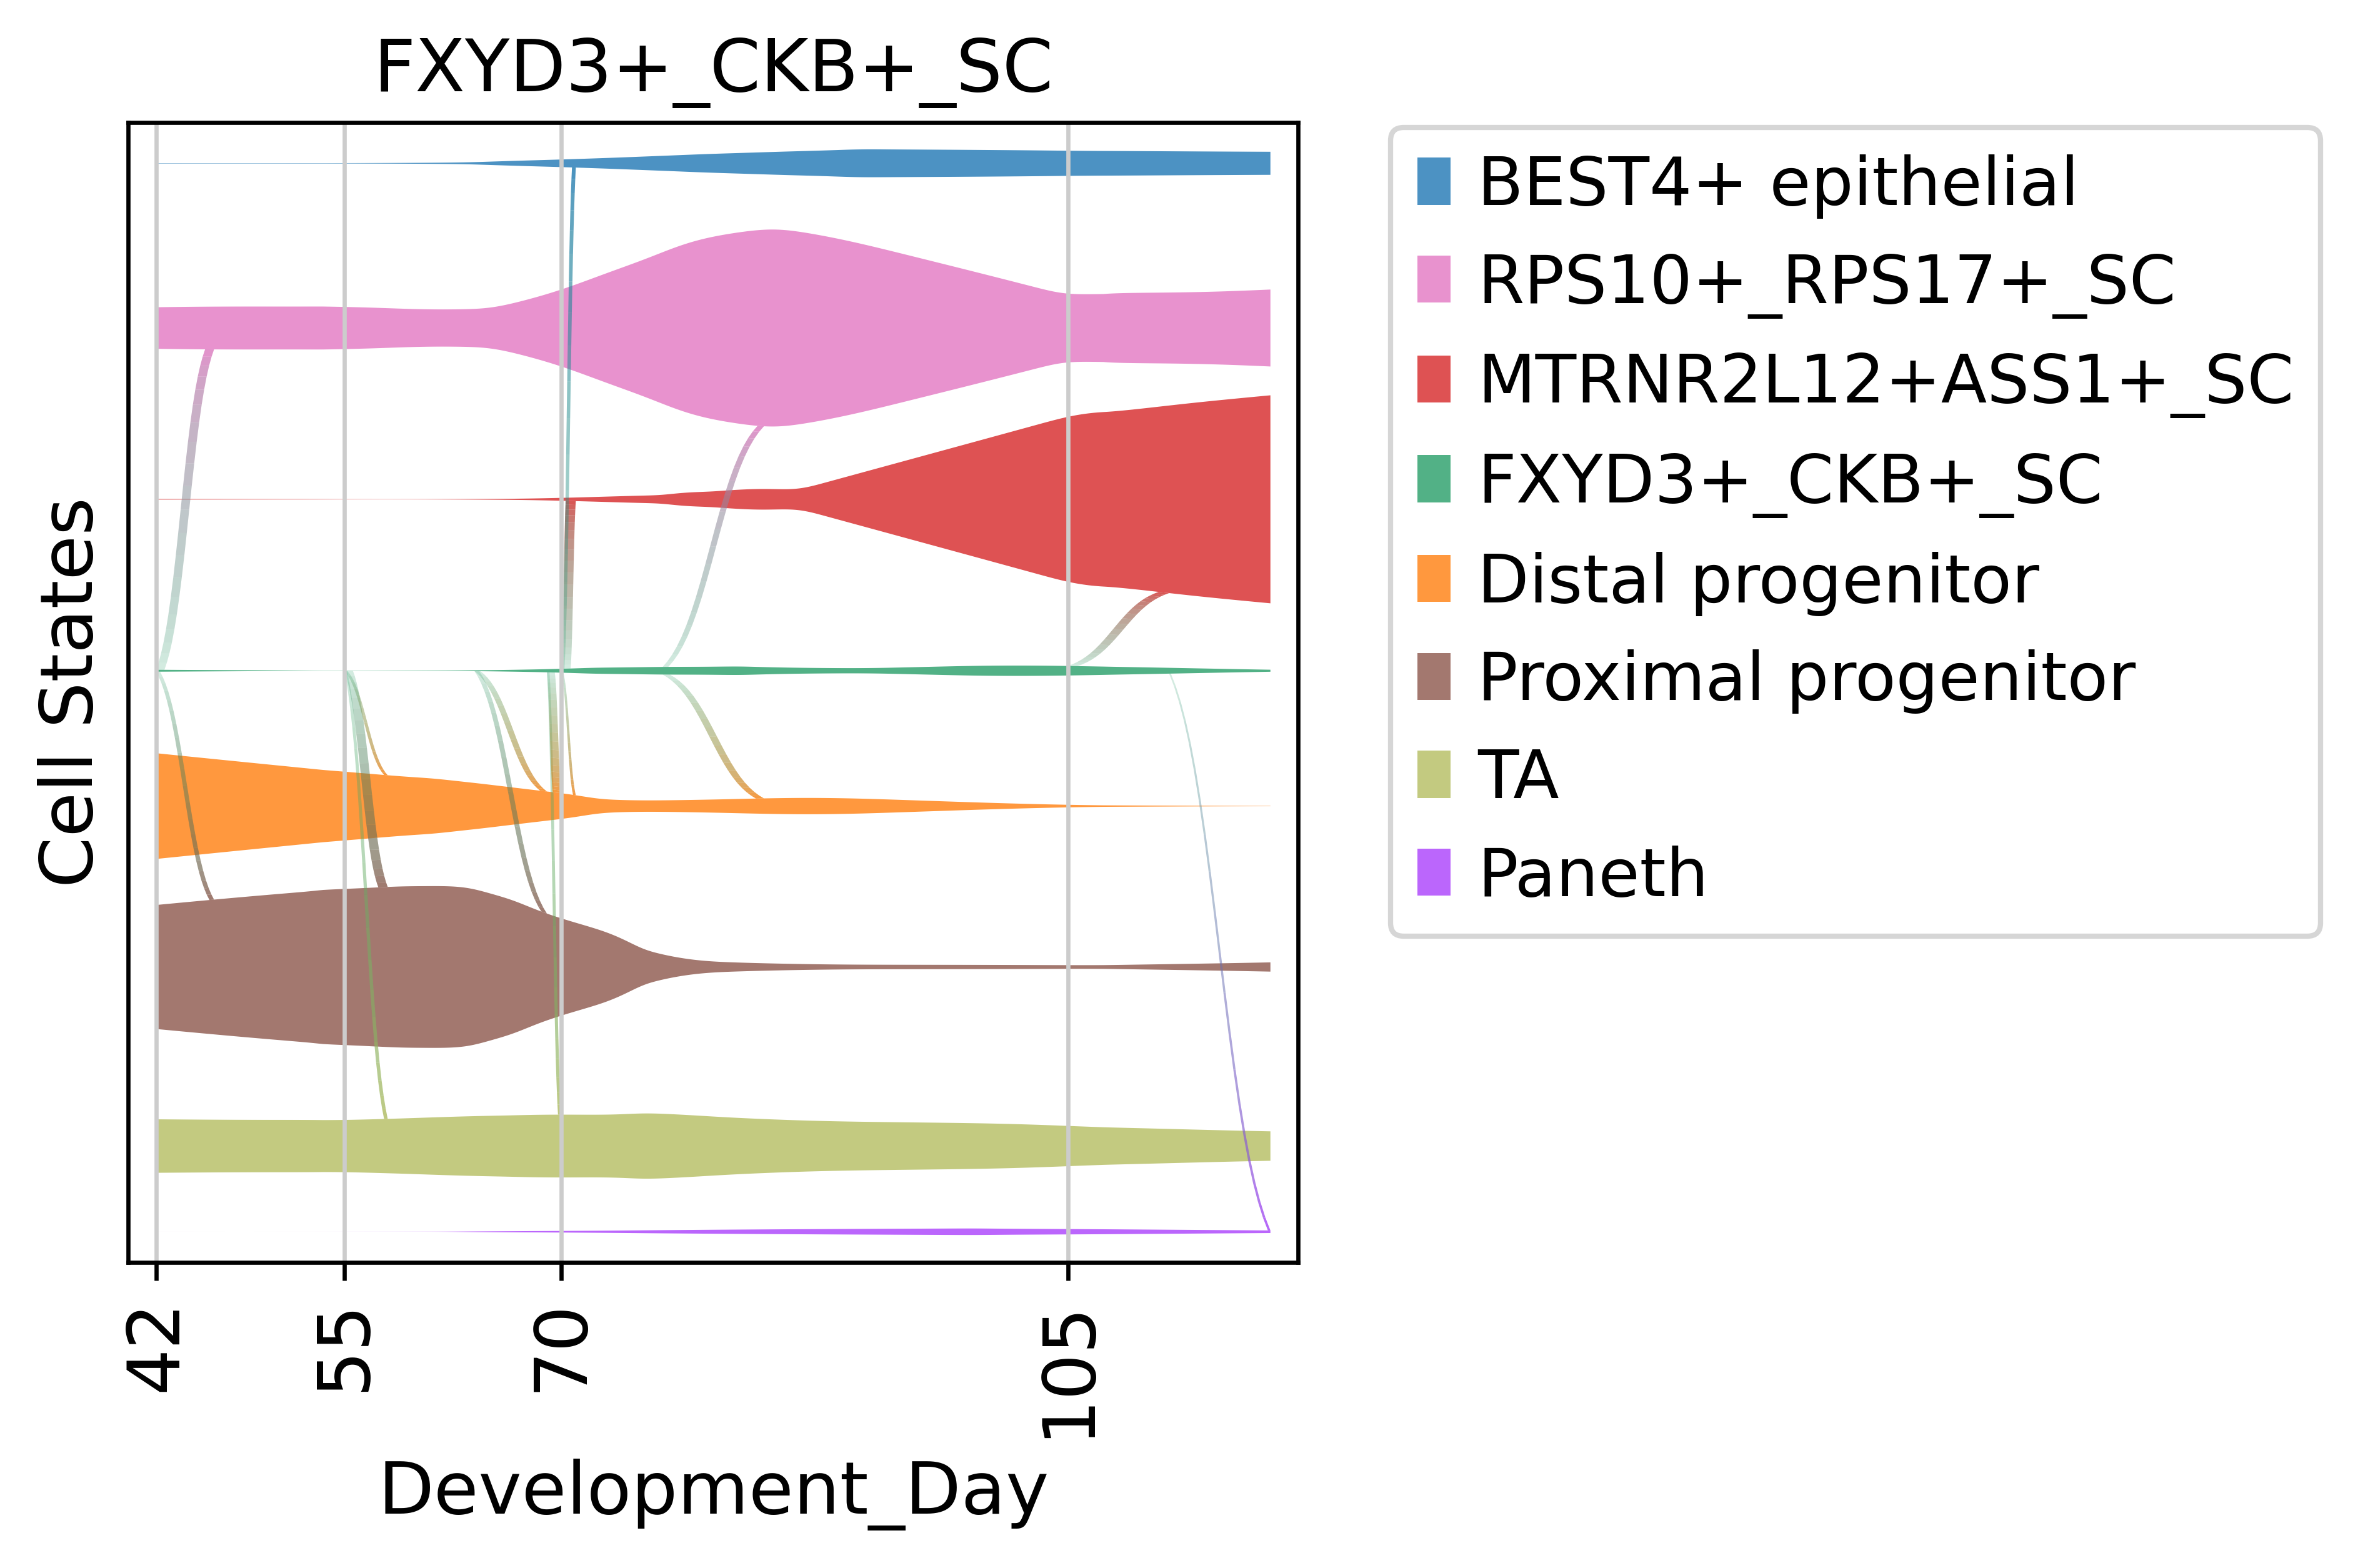

In [21]:
sc.set_figure_params(dpi=300)
ax = tmk.plot_single_flow(
    cluster_key="Cell States",
    time_key="Development_Day",
    min_flow=0.1,
    xticks_step_size=4,
    show=False,
    cluster = 'FXYD3+_CKB+_SC'
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Write anndata 

In [22]:
tmk.write_to_adata()

In [23]:
adata

AnnData object with n_obs × n_vars = 22985 × 25445
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'Development_Week', 'Development_Day', 'proliferation', 'apoptosis'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: 'Cell States_colors', 'Donor_ID_colors', 'Library_Preparation_Protocol_colors', 'Study_name_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap', 'log1p', 'pca', 'T_fwd_params'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'T_f

In [24]:
# Save anndata file 
output_path = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_undifferentiated_cells/Fetal_undifferentiated_CellRank_experimental_time.h5ad'
adata.write(output_path)